In [ ]:
#  IMPORTS Y PATHS

import os
import re
import numpy as np
import pandas as pd
from pathlib import Path
import requests

# Ruta base (ajústala si cambias carpeta)
base= Path("//tfm_andrea_ramos")
base_path = base / "data/PRJEB29127/functional_annotation"
outdir = base / "results"
outdir.mkdir(exist_ok=True)

def leer_emapper(archivo: Path) -> pd.DataFrame:
    """Lee un .emapper.annotations y devuelve columnas: sample_id, query, KEGG_Module (1 módulo por fila)."""
    sample_id = Path(archivo).name.split(".")[0]
    header = None
    with open(archivo, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            if line.startswith("#query"):
                header = line.lstrip("#").strip().split("\t")
                break
    if header is None:
        raise ValueError(f"No se encontró cabecera '#query' en {archivo}")

    df = pd.read_csv(archivo, sep="\t", comment="#", names=header, dtype=str)
    df = df[["query", "KEGG_Module"]].dropna()
    df = df[df["KEGG_Module"] != "-"]
    df["KEGG_Module"] = df["KEGG_Module"].str.split(",")
    df = df.explode("KEGG_Module")
    df["KEGG_Module"] = df["KEGG_Module"].str.strip()
    df = df[df["KEGG_Module"] != ""]
    df.insert(0, "sample_id", sample_id)
    return df[["sample_id", "query", "KEGG_Module"]]

def resumen_modulos(df: pd.DataFrame):
    """Devuelve: long_counts (sample_id, KEGG_Module, n_proteins) y matriz (muestras x módulos)."""
    long_counts = (
        df.groupby(["sample_id", "KEGG_Module"])["query"]
        .nunique()
        .reset_index(name="n_proteins")
    )
    matriz = long_counts.pivot(index="sample_id", columns="KEGG_Module",
                               values="n_proteins").fillna(0).astype(int)
    return long_counts, matriz

def obtener_kegg() -> pd.DataFrame:
    """Tabla KEGG con KEGG_Module, Module_name y Module_description."""
    url = "https://rest.kegg.jp/list/module"
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    lines = [l.split("\t") for l in r.text.strip().split("\n")]
    df = pd.DataFrame(lines, columns=["KEGG_Module", "Description"])
    df["KEGG_Module"] = df["KEGG_Module"].str.replace("module:", "", regex=False).str.strip()
    df["Module_name"] = df["Description"].str.split(",", n=1).str[0]
    df["Module_description"] = df["Description"]
    return df.drop_duplicates(subset=["KEGG_Module"])

def porcentaje_no_mapeado(modulos, ref_df):
    encontrados = set(ref_df["KEGG_Module"])
    presentes = set(modulos)
    faltan = [m for m in presentes if m not in encontrados]
    return round(100 * len(faltan) / len(presentes), 2) if presentes else 0.0

def sparsidad(matriz: pd.DataFrame) -> float:
    total = matriz.size
    ceros = (matriz == 0).sum().sum()
    return round(100 * ceros / total, 2) if total else 0.0

In [16]:
# CARGA ANOTACIONES Y MATRIZ DE ABUNDANCIAS (E-MAPPER -> LONG Y MATRIZ)

annotations_files = list(base_path.glob("ERR*.emapper.annotations"))
print(f"Archivos .emapper.annotations encontrados: {len(annotations_files)}")

dfs = []
for f in annotations_files:
    try:
        dfs.append(leer_emapper(f))
    except Exception as e:
        print(f"[AVISO] Problema con {f}: {e}")

if not dfs:
    raise RuntimeError("No se pudieron leer anotaciones válidas.")

conteo = pd.concat(dfs, ignore_index=True)
print(f"Total de anotaciones KEGG_Module: {len(conteo):,}")

long_counts, matriz = resumen_modulos(conteo)
print(f"Dimensión matriz (muestras x módulos): {matriz.shape} | Sparsidad: {sparsidad(matriz)}%")

Archivos .emapper.annotations encontrados: 171
Total de anotaciones KEGG_Module: 9,237,561
Dimensión matriz (muestras x módulos): (171, 757) | Sparsidad: 30.07%


In [17]:
# ANOTACIÓN DE MÓDULOS KEGG  Y FILTRO

try:
    kmap = obtener_kegg()
    pct_unmapped = porcentaje_no_mapeado(matriz.columns, kmap)
    print(f"% módulos de tu matriz que no aparecen en KEGG: {pct_unmapped}%")

    # Long anotado y matriz reducida solo a módulos que se correspondan con una descripción en KEGG
    long_counts_annot = long_counts.merge(kmap, on="KEGG_Module", how="inner")
    mods_valid = set(long_counts_annot["KEGG_Module"])
    matriz = matriz.loc[:, sorted([c for c in matriz.columns if c in mods_valid])]
    print(f"Módulos con descripción retenidos: {matriz.shape[1]}")
except Exception as e:
    print("[AVISO] Falló KEGG, continuo sin anotación:", e)
    kmap = None
    long_counts_annot = long_counts.copy()
    long_counts_annot["Module_name"] = long_counts_annot["KEGG_Module"]
    long_counts_annot["Module_description"] = "NA"

% módulos de tu matriz que no aparecen en KEGG: 55.88%
Módulos con descripción retenidos: 334


In [20]:
# METADATOS Y MERGE

meta_path = base_path / "zhu_data.csv"
meta_raw = pd.read_csv(meta_path)

if "NCBI_accession" not in meta_raw.columns or "study_condition" not in meta_raw.columns:
    raise RuntimeError("zhu_data.csv debe tener columnas NCBI_accession y study_condition")

meta = meta_raw[["NCBI_accession", "study_condition"]].copy()
meta["sample_id"] = (
    meta["NCBI_accession"].astype(str).str.extract(r"(ERR\d+)", expand=False).str.upper()
)
meta["group"] = meta["study_condition"].astype(str).str.strip().str.lower()
meta = meta[["sample_id", "group"]].dropna().drop_duplicates("sample_id")

# Mantener solo las muestras que están en la matriz y con grupos válidos
meta = meta[meta["group"].isin(["control", "schizophrenia"])]
intersec = sorted(set(matriz.index) & set(meta["sample_id"]))
matriz = matriz.loc[intersec]

# Añadir columna group para inspección
matriz_con_meta = matriz.copy()
matriz_con_meta.insert(0, "group", matriz_con_meta.index.map(dict(zip(meta["sample_id"], meta["group"]))))

# Objetos finales para DESeq2
counts_df = matriz_con_meta.drop(columns=["group"]).astype(int)
metadata = pd.DataFrame({"group": matriz_con_meta["group"].astype(str).str.lower()},
                        index=counts_df.index)

# Filtrado baja abundancia (>=10 cuentas totales por módulo)
counts_df = counts_df.loc[:, (counts_df.sum(axis=0) >= 10)]

print("DESeq2 -> counts_df:", counts_df.shape, "| metadata:", metadata.shape)
print("Grupos:", metadata["group"].value_counts().to_dict())


DESeq2 -> counts_df: (171, 305) | metadata: (171, 1)
Grupos: {'schizophrenia': 90, 'control': 81}


In [21]:
# PYDESEQ2: AJUSDE Y ESTADÍSTICAS
import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference

# Categoría con referencia explícita (control primero)
metadata["group"] = pd.Categorical(metadata["group"], categories=["control","schizophrenia"], ordered=True)

inference = DefaultInference(n_cpus=None)
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design="~ group",
    refit_cooks=True,
    inference=inference,
)
dds.deseq2()

# Contraste: schizophrenia vs control
ds = DeseqStats(
    dds,
    contrast=["group", "schizophrenia", "control"],
    alpha=0.05,
    cooks_filter=True,
    independent_filter=True,
    inference=inference,
)
ds.summary()  # calcula p, padj y construye results_df (pre-shrink)
res_pre = ds.results_df.sort_values("padj", na_position="last").copy()

Matplotlib is building the font cache; this may take a moment.


Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.06 seconds.

Fitting dispersion trend curve...
/opt/homebrew/Caskroom/miniforge/base/envs/tfm_andrea/lib/python3.14/site-packages/pydeseq2/dds.py:807: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.00 seconds.

Fitting MAP dispersions...
... done in 0.06 seconds.

Fitting LFCs...
... done in 0.05 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: group schizophrenia vs control
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
KEGG_Module                                                             
M00001       755.155210        0.008188  0.009872  0.829474  0.406836   
M00002       405.801700        0.004043  0.014358  0.281560  0.778281   
M00003       525.165444        0.014409  0.010788  1.335679  0.181654   
M00004       451.492611        0.006004  0.010786  0.556618  0.577789   
M00005        66.487499        0.020617  0.026422  0.780303  0.435213   
...                 ...             ...       ...       ...       ...   
M00841       186.060300       -0.021877  0.016232 -1.347745  0.177740   
M00842        67.482778       -0.024876  0.026574 -0.936131  0.349206   
M00843        67.491975       -0.024243  0.026568 -0.912476  0.361518   
M00844       162.463244        0.009870  0.017051  0.578824  0.562708   
M00845       264.751661       -0.004839  0.013454 -0.35

... done in 0.07 seconds.



In [23]:
# LFC SHRINK + ANOTACIÓN KEGG
# Guardamos p/padj de Wald y sustituimos solo LFC/SE por shrink
ds.lfc_shrink(coeff="group[T.schizophrenia]")
shrunk = ds.results_df[["log2FoldChange","lfcSE"]].copy()

res_final = (
    res_pre.drop(columns=["log2FoldChange","lfcSE"], errors="ignore")
           .join(shrunk)
           .reset_index()
)
if kmap is not None:
    res_final = res_final.merge(
        kmap[["KEGG_Module","Module_name","Module_description"]],
        on="KEGG_Module", how="left"
    )

# Guardar
res_pre.reset_index().to_csv(outdir / "deseq2_pre_shrink.csv", index=False)
res_final.to_csv(outdir / "deseq2_final_shrunkLFC_origP.csv", index=False)
print("Guardados:", outdir / "deseq2_pre_shrink.csv", "|", outdir / "deseq2_final_shrunkLFC_origP.csv")

Shrunk log2 fold change & Wald test p-value: group[T.schizophrenia]
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
KEGG_Module                                                             
M00001       755.155210        0.000087  0.001489  0.829474  0.406836   
M00002       405.801700        0.000020  0.001488  0.281560  0.778281   
M00003       525.165444        0.000151  0.001512  1.335679  0.181654   
M00004       451.492611        0.000052  0.001493  0.556618  0.577789   
M00005        66.487499        0.000008  0.001506  0.780303  0.435213   
...                 ...             ...       ...       ...       ...   
M00841       186.060300       -0.000096  0.001510 -1.347745  0.177740   
M00842        67.482778       -0.000036  0.001506 -0.936131  0.349206   
M00843        67.491975       -0.000029  0.001506 -0.912476  0.361518   
M00844       162.463244        0.000033  0.001503  0.578824  0.562708   
M00845       264.751661       -0.000012  0.001498 -0.359

Fitting MAP LFCs...
/opt/homebrew/Caskroom/miniforge/base/envs/tfm_andrea/lib/python3.14/site-packages/pydeseq2/utils.py:1088: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
... done in 0.07 seconds.



In [24]:
# DISTRIBUCIÓN LFC Y PADJ
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = res_final.copy()  # tabla final con LFC shrink + p/padj

print("Resumen LFC:")
print(df["log2FoldChange"].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]))

print("\nResumen padj:")
print(df["padj"].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]))

# proporción de módulos con padj < 0.05, 0.1, 0.2
for thr in [0.05, 0.1, 0.2]:
    prop = (df["padj"] < thr).mean() * 100
    print(f"padj < {thr}: {prop:.2f}% de los módulos")

Resumen LFC:
count    305.000000
mean       0.000111
std        0.012943
min       -0.129514
1%        -0.000307
5%        -0.000095
25%       -0.000006
50%        0.000001
75%        0.000008
95%        0.000120
99%        0.061523
max        0.084486
Name: log2FoldChange, dtype: float64

Resumen padj:
count    305.000000
mean       0.814659
std        0.249912
min        0.001806
1%         0.027378
5%         0.243186
25%        0.688905
50%        0.977828
75%        0.999723
95%        0.999723
99%        0.999723
max        0.999723
Name: padj, dtype: float64
padj < 0.05: 1.64% de los módulos
padj < 0.1: 1.64% de los módulos
padj < 0.2: 4.59% de los módulos


In [25]:
# SIGNIFICATIVOS + CUENTAS NORMALIZADAS
# Criterio reproducible tras estudiar la distribución
LFC_MIN = 0.02   
PADJ_MAX = 0.2

sig = res_final[(res_final["padj"] < PADJ_MAX) & (res_final["log2FoldChange"].abs() >= LFC_MIN)].copy()
sig = sig.sort_values(["padj","log2FoldChange"], ascending=[True, False])
print(f"Significativos (padj<{PADJ_MAX} & |log2FC|>={LFC_MIN}): {sig.shape[0]}")
sig.to_csv(outdir / "deseq2_significativos.csv", index=False)

# Cuentas normalizadas (size-factor adjusted) desde el objeto
norm_counts = pd.DataFrame(
    dds.layers["normed_counts"],
    index=dds.obs_names,
    columns=dds.var_names
)
norm_counts.to_csv(outdir / "norm_counts.csv")
print("norm_counts guardado:", outdir / "norm_counts.csv")

Significativos (padj<0.2 & |log2FC|>=0.02): 7
norm_counts guardado: /Users/alvaroroman/Developer/pruebas/tfm_andrea_ramos/results/norm_counts.csv


In [26]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

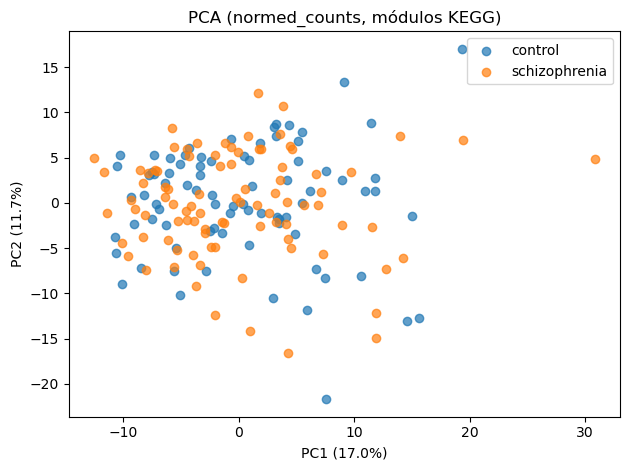

In [27]:
# QC: PCA
X = StandardScaler(with_mean=True, with_std=True).fit_transform(norm_counts)
pca = PCA(n_components=2, random_state=0).fit(X)
PC = pca.transform(X)
pc_df = pd.DataFrame(PC, index=norm_counts.index, columns=["PC1","PC2"])
pc_df["group"] = metadata.loc[pc_df.index, "group"].astype(str)

plt.figure()
for g in pc_df["group"].unique():
    sub = pc_df[pc_df["group"] == g]
    plt.scatter(sub["PC1"], sub["PC2"], label=g, alpha=0.7)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend()
plt.title("PCA (normed_counts, módulos KEGG)")
plt.tight_layout()
plt.show()

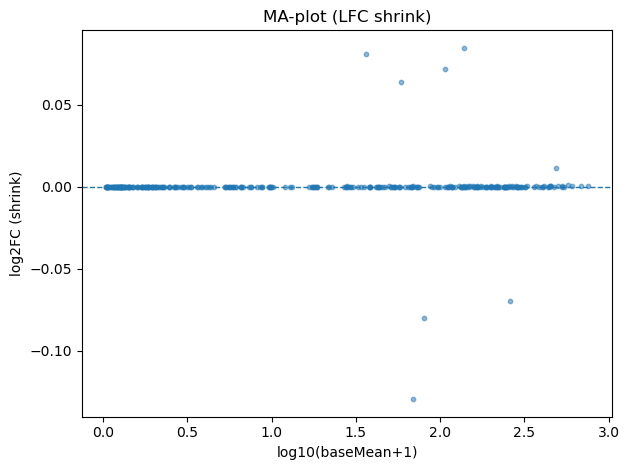

In [28]:
# QC: MA-plot
dfp = res_final.replace([np.inf,-np.inf], np.nan).dropna(subset=["baseMean","log2FoldChange","padj","pvalue"])
plt.figure()
plt.scatter(np.log10(dfp["baseMean"]+1), dfp["log2FoldChange"], s=10, alpha=0.5)
plt.axhline(0, ls="--", lw=1)
plt.xlabel("log10(baseMean+1)")
plt.ylabel("log2FC (shrink)")
plt.title("MA-plot (LFC shrink)")
plt.tight_layout()
plt.show()

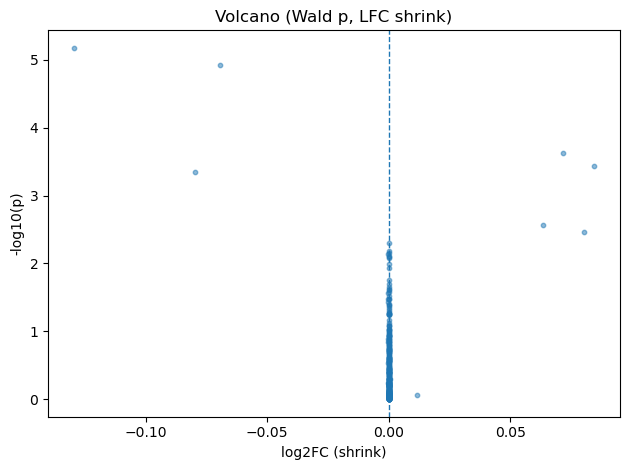

In [30]:
# QC: heatmap
plt.figure()
plt.scatter(dfp["log2FoldChange"], -np.log10(dfp["pvalue"].clip(lower=1e-300)), s=10, alpha=0.5)
plt.axvline(0, ls="--", lw=1)
plt.xlabel("log2FC (shrink)")
plt.ylabel("-log10(p)")
plt.title("Volcano (Wald p, LFC shrink)")
plt.tight_layout()
plt.show()